In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats

In [158]:
# Define data directory
base_dir = "../results/experiment-001"
# Find all folders (models + control)
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]


## Trapezoid Rule for Total Energy

We analyze each csv for each model. We use the Trapezoid rule to calculate the Total Energy (Joules) for a specific trial and we repeat 30 Times: Do this for all 30 CSVs in that model's folder. 

In [159]:
# We will store every single trial's final result in this list
all_trials_data = []

print("Processing all CSV files using the Trapezoid Rule...")

for folder in model_folders:
    # Find all 30 CSVs in this folder
    csv_pattern = os.path.join(base_dir, folder, "trial-*.csv")
    csv_files = glob.glob(csv_pattern)
    
    for file in csv_files:
        df = pd.read_csv(file)
        
        # Failsafe: check if necessary columns exist
        if 'GPU0_POWER (mWatts)' not in df.columns or 'GPU0_TEMPERATURE' not in df.columns:
            continue
            
        # Convert timestamp to elapsed Seconds (starting from 0)
        time_sec = (df['Time'] - df['Time'].min()) / 1000.0
        
        # Convert milliWatts to standard Watts
        power_watts = df['GPU0_POWER (mWatts)'] / 1000.0
        
        # Calculate Area Under the Curve (Total Joules)
        total_energy_joules = np.trapezoid(y=power_watts, x=time_sec)
        
        # Get the total duration
        total_time_seconds = time_sec.max()
        
        # Extract Temperature Metrics
        max_temp = df['GPU0_TEMPERATURE'].max()
        start_temp = df['GPU0_TEMPERATURE'].iloc[0]
        
        # Store the calculated metrics for THIS trial
        all_trials_data.append({
            'Model': folder,
            'Trial_Name': os.path.basename(file),
            'Total_Energy_Joules': total_energy_joules,
            'Total_Time_Seconds': total_time_seconds,
            'Max_Temp': max_temp,      # Add this
            'Start_Temp': start_temp   # Add this
        })

# Convert the master list into a DataFrame
df_results = pd.DataFrame(all_trials_data)

print(f"\nSuccessfully processed {len(df_results)} trials.")
print("\nHere is a sneak peek of the dataset:")
display(df_results.head())

Processing all CSV files using the Trapezoid Rule...

Successfully processed 210 trials.

Here is a sneak peek of the dataset:


,Model,Trial_Name,Total_Energy_Joules,Total_Time_Seconds,Max_Temp,Start_Temp
0,deepseek-r1_8b-llama-distill-q8_0,trial-026.csv,155.065131,6.205,47,42
1,deepseek-r1_8b-llama-distill-q8_0,trial-027.csv,2765.310940,38.820,55,43
2,deepseek-r1_8b-llama-distill-q8_0,trial-025.csv,630.366980,11.206,50,43
3,deepseek-r1_8b-llama-distill-q8_0,trial-019.csv,685.746083,12.606,50,43
4,deepseek-r1_8b-llama-distill-q8_0,trial-018.csv,778.247545,12.607,50,43


## Anomalies Detection

Running the following block of code, we identified that 5 out of our 210 executions were anomalous. Four trials reached our 60-second hardware timeout limit and were forcefully aborted, resulting in extreme energy spikes. One trial probably experienced a software crash (terminating in 0.6 seconds). Following standard data-cleaning procedures, these outliers were discarded to prevent skewed distributions. Furthermore, sensor data confirmed that the GPU temperature never exceeded 66°C, validating that our cooling and resting strategy effectively prevented thermal throttling.

In [160]:
print("=== OUTLIER DETECTION REPORT ===\n")
valid_trials = []

# Flag and filter outliers per model
for model in df_results['Model'].unique():
    model_df = df_results[df_results['Model'] == model].copy()
    
    # Calculate Mean and Standard Deviation for Time
    mean_time = model_df['Total_Time_Seconds'].mean()
    std_time = model_df['Total_Time_Seconds'].std()
    
    # We use different rules for the control group vs the AI models
    if model == 'control':
        # For the control group, we filter out extreme crashes and anomalies > 3 standard deviations
        outlier_condition = (
            (model_df['Total_Time_Seconds'] < 1.0) | 
            (np.abs(model_df['Total_Time_Seconds'] - mean_time) > 3 * std_time)
        )
    else:
        # For the AI models, we filter out crashes, timeouts (>= 59s), and anomalies > 3 standard deviations
        outlier_condition = (
            (model_df['Total_Time_Seconds'] < 1.0) | 
            (model_df['Total_Time_Seconds'] >= 59.0) |
            (np.abs(model_df['Total_Time_Seconds'] - mean_time) > 3 * std_time)
        )
    
    outliers = model_df[outlier_condition]
    clean_data = model_df[~outlier_condition]
    valid_trials.append(clean_data)
    
    if not outliers.empty and model != 'control':
        print(f"⚠️ {model} had {len(outliers)} anomalous runs discarded:")
        for _, row in outliers.iterrows():
            print(f"   - {row['Trial_Name']}: Time = {row['Total_Time_Seconds']:.2f}s, Energy = {row['Total_Energy_Joules']:.0f} J")
        print()

# Create your final, clean dataset!
clean_df = pd.concat(valid_trials)

print(f"✅ Data cleaning complete. Retained {len(clean_df)} valid trials out of {len(df_results)} total.")

=== OUTLIER DETECTION REPORT ===

⚠️ deepseek-r1_8b-llama-distill-q8_0 had 2 anomalous runs discarded:
   - trial-001.csv: Time = 59.83s, Energy = 4092 J
   - trial-003.csv: Time = 0.60s, Energy = 8 J

⚠️ llama3.1_8b-instruct-q8_0 had 1 anomalous runs discarded:
   - trial-001.csv: Time = 59.83s, Energy = 4054 J

⚠️ deepseek-r1_8b-llama-distill-fp16 had 1 anomalous runs discarded:
   - trial-025.csv: Time = 59.83s, Energy = 3965 J

⚠️ deepseek-r1_8b-llama-distill-q4_K_M had 1 anomalous runs discarded:
   - trial-001.csv: Time = 59.83s, Energy = 4118 J

✅ Data cleaning complete. Retained 204 valid trials out of 210 total.


### Checking Temperature

Scanning temperature data from extracted results...

The absolute Maximum GPU Temperature recorded was 65°C.
Conclusion Validated: Thermal throttling was successfully prevented.


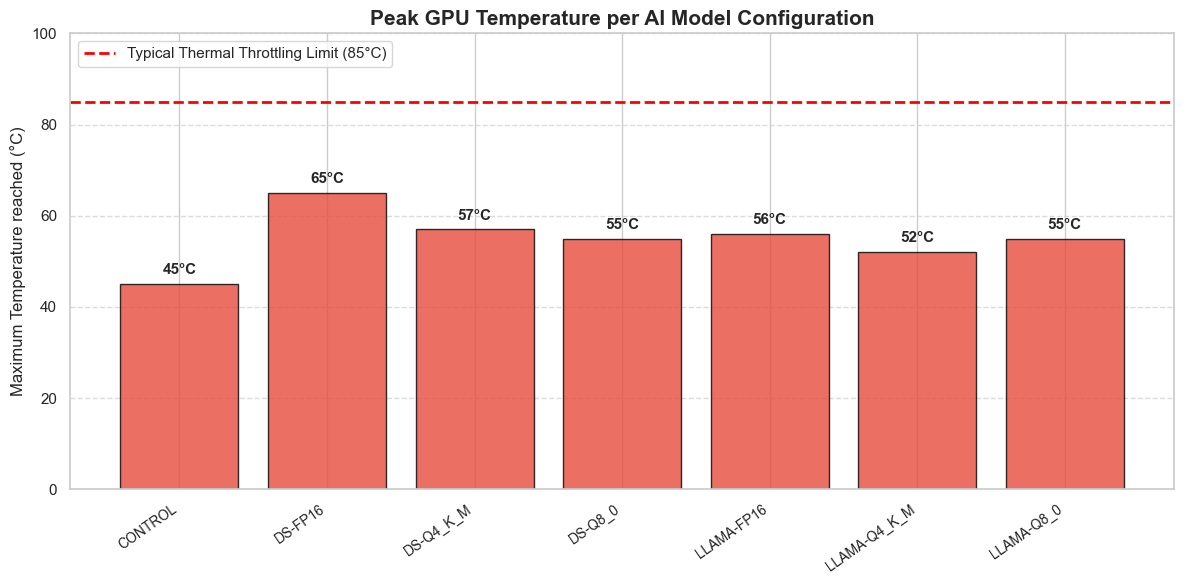

In [161]:
print("Scanning temperature data from extracted results...")

# Get the peak temperature per model directly from our clean DataFrame
# This finds the single highest temperature reached in ANY trial for each model
max_temps_series = clean_df.groupby('Model')['Max_Temp'].max()

# Identify the absolute global maximum recorded across the whole experiment
global_max = max_temps_series.max()

# Print the final conclusive statement
print(f"\nThe absolute Maximum GPU Temperature recorded was {global_max}°C.")
if global_max <= 66:
    print("Conclusion Validated: Thermal throttling was successfully prevented.")
else:
    print(f"Note: Peak temperature reached {global_max}°C. Still likely below throttling limits.")

# Visual proof for the report
plt.figure(figsize=(12, 6))

# Shorten the names for the X-axis labels to match previous plots
short_names = [name.replace('deepseek-r1_8b-llama-distill-', 'DS-').replace('llama3.1_8b-instruct-', 'Llama-').upper() 
               for name in max_temps_series.index]

bars = plt.bar(short_names, max_temps_series.values, color='#e74c3c', edgecolor='black', alpha=0.8)

# Add the 85°C safety line (standard for NVIDIA/modern GPUs)
plt.axhline(y=85, color='red', linestyle='--', linewidth=2, label='Typical Thermal Throttling Limit (85°C)')

plt.title("Peak GPU Temperature per AI Model Configuration", fontsize=15, fontweight='bold')
plt.ylabel("Maximum Temperature reached (°C)", fontsize=12)
plt.xticks(rotation=35, ha='right', fontsize=10)

plt.ylim(0, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')

# Add the exact temperature number on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1.5, f"{int(yval)}°C", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis

### Violin Box-Plot
- This chart is a hybrid of two statistical tools. The Boxplot shows the summary statistics (median, quartiles, and outliers). It focuses on where the "middle" of the data is. The Violin is a Kernel Density Plot. The wider the "belly" of the violin, the more trials resulted in that specific energy value. It shows the probability density of your 30 trials.

- The Median: the horizontal line inside the box. This is the middle value of your 30 trials. If you lined up all trials from lowest to highest energy, this is the one in the center.
- Interquartile Range: the box represents the middle 50% of your data. The bottom of the box is the 25th percentile ($Q_1$) and the top is the 75th percentile ($Q_3$).
- Whiskers (the vertical lines): These extend to show the range of the data, excluding outliers.
- Outliers (the small dots outside the whiskers): These are individual trials that were significantly higher or lower than the rest. In energy testing, these often happen due to "noise" (like a background system process starting during a trial)

/var/folders/2n/l5k67t1n04s7fbzz55h9cg7r0000gn/T/ipykernel_77665/2932741958.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


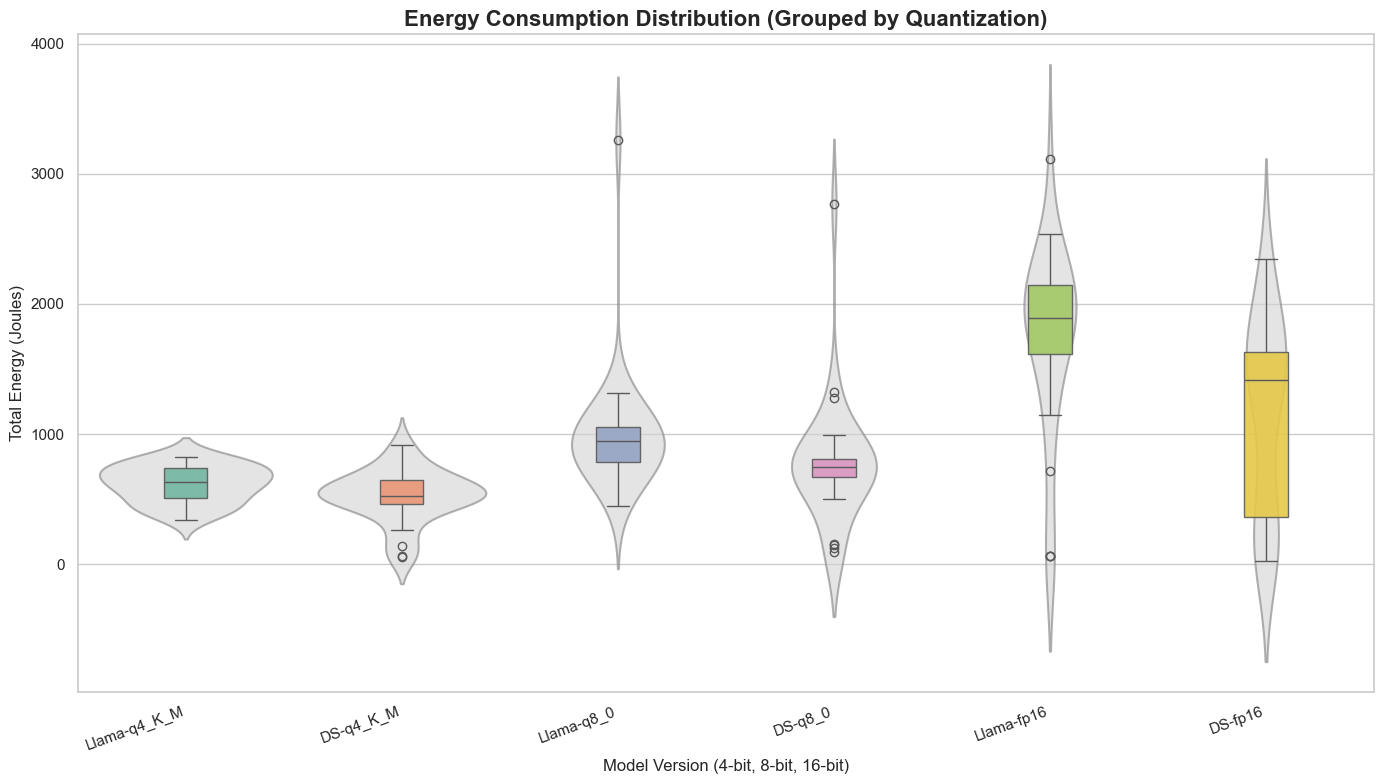

In [162]:
plot_df = clean_df[clean_df['Model'] != 'control'].copy()

# Shorten the names to make the X-axis readable
plot_df['Model_Short'] = plot_df['Model'].str.replace('deepseek-r1_8b-llama-distill-', 'DS-')
plot_df['Model_Short'] = plot_df['Model_Short'].str.replace('llama3.1_8b-instruct-', 'Llama-')

# We group 4-bit together, then 8-bit, then 16-bit
quantization_order = [
    'Llama-q4_K_M', 'DS-q4_K_M', 
    'Llama-q8_0',   'DS-q8_0', 
    'Llama-fp16',   'DS-fp16'
]

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Create the Violin Plot, passing the new order
sns.violinplot(
    x='Model_Short', 
    y='Total_Energy_Joules', 
    data=plot_df, 
    order=quantization_order,
    inner=None, 
    color="lightgray", 
    linewidth=1.5,
    alpha=0.6
)

# Overlay the Box Plot, passing the SAME order so they align perfectly
sns.boxplot(
    x='Model_Short', 
    y='Total_Energy_Joules', 
    data=plot_df, 
    order=quantization_order, 
    width=0.2, 
    boxprops={'zorder': 2, 'alpha': 0.9},
    palette="Set2" 
)

plt.title("Energy Consumption Distribution (Grouped by Quantization)", fontsize=16, fontweight='bold')
plt.xlabel("Model Version (4-bit, 8-bit, 16-bit)", fontsize=12)
plt.ylabel("Total Energy (Joules)", fontsize=12)

plt.xticks(rotation=20, ha='right', fontsize=11)

plt.tight_layout()
plt.show()

#### **Analysis of the Results**


**4-bit Comparison**
At the 4-bit level, both models are at their most sustainable, but there are subtle differences:
- Median Energy: DeepSeek (DS-q4_K_M) is slightly more efficient than Llama. Its median sits roughly around 550 Joules, while Llama's is closer to 650 Joules.
- Stability: Both models show very "tight" boxes and short violins, meaning the energy consumption is extremely predictable at this low precision.
- Anomalies: DeepSeek shows a small cluster of low-energy outliers (dots near the 0-100 range), which might indicate specific trials that finished exceptionally fast or failed to process fully.

**8-bit Comparison**
- As we move to 8-bit, the energy "tax" increases for both, and we start to see less predictable behavior:
- Median Energy: DeepSeek (DS-q8_0) remains the winner for sustainability, with a median around 750 Joules compared to Llama's ~950 Joules.
- The "Spike" Risk: Both models exhibit very long "necks" in their violins stretching toward the top. This shows that while most trials stay low, 8-bit quantization occasionally triggers massive energy spikes (up to 3000+ Joules).
- DeepSeek is generally more efficient, but Llama's distribution is slightly more "bottom-heavy" (more trials clustered at the median).

**16-bit (fp16) Comparison**: High Power vs. High Variance

This is where the models behave most differently:
- Median Energy: DeepSeek (DS-fp16) has a significantly lower median (around 1400 Joules) than Llama (around 1900 Joules). From a sustainability standpoint, DeepSeek is the clear choice here.
- Consistency (The Box Height): This is the most striking difference. Llama's box is relatively small, meaning it is consistently expensive. DeepSeek's yellow box is very tall, meaning it is inconsistent. Some trials used ~400 Joules while others used ~2300 Joules.
- ***The Sustainability Trade-off: If your goal is "Guaranteed Energy Cost," Llama is better because you know exactly what you'll get. If your goal is "Average Energy Savings," DeepSeek is better, even though it's less predictable.***

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**The 4-bit Models** (Llama-q4_K_M & DS-q4_K_M) 

These are your most energy efficient options. The median energy is lowest here (around 500-600 Joules). Notice how "short" the violins are. This means the energy consumption is very predictable and consistent across trials. 

**The 8-bit Models** (Llama-q8_0 & DS-q8_0)

There is a noticeable increase in energy compared to 4-bit. The "Long Neck" (Llama-q8_0): Look at the thin line stretching way up to 3000+ Joules. This indicates a massive outlier. One of your trials took nearly 3x more energy than the others, likely due to a hardware spike. 

**The 16-bit Models** (Llama-fp16 & DS-fp16)

These have the highest median energy (approaching 2000 Joules). 
**DeepSeek (DS-fp16) variance**: Notice that the yellow box for DeepSeek is much "taller" than the Llama one. This means DeepSeek’s energy consumption at 16-bit was less stable, the energy used varied significantly from one trial to the next.

#### **Key Takeaways**
- Quantization = Sustainability: Moving from 16-bit (fp16) to 4-bit (q4) reduces energy consumption by roughly 70-75% based on your medians.
- Llama vs. DeepSeek: At lower quantizations (4-bit/8-bit), the two models perform very similarly. However, at 16-bit, Llama seems to have a higher "floor" (the whole box is higher), while DeepSeek has a wider "spread" of energy usage.
- The Outlier Problem: Your 8-bit and 16-bit Llama tests show extreme outliers (the dots at 3000+). In a sustainable SE paper, we should mention that while average energy is one metric, tail latency/energy (the worst-case scenario) is also important for grid stability.

### Shapiro - Wilk test & T-test for Normal or Mann-Whitney U Test for not Normal

In [163]:
# Define the pairs we want to compare in a list
model_pairs = [
    ('llama3.1_8b-instruct-q4_K_M', 'deepseek-r1_8b-llama-distill-q4_K_M', '4-bit'),
    ('llama3.1_8b-instruct-q8_0', 'deepseek-r1_8b-llama-distill-q8_0', '8-bit'),
    ('llama3.1_8b-instruct-fp16', 'deepseek-r1_8b-llama-distill-fp16', '16-bit')
]

for llama_name, ds_name, precision in model_pairs:
    print(f"======================================================")
    print(f"=== STATISTICAL SIGNIFICANCE TEST: {precision.upper()} MODELS ===")
    print(f"======================================================\n")
    
    # Isolate the data for the current pair
    llama_data = clean_df[clean_df['Model'] == llama_name]['Total_Energy_Joules']
    ds_data = clean_df[clean_df['Model'] == ds_name]['Total_Energy_Joules']
    
    # The Normality Test (Shapiro-Wilk)
    stat_l, p_l = stats.shapiro(llama_data)
    stat_d, p_d = stats.shapiro(ds_data)
    
    print(f"Shapiro-Wilk p-value (Llama): {p_l:.5f}")
    print(f"Shapiro-Wilk p-value (DeepSeek): {p_d:.5f}")
    
    # Choose the right test dynamically
    if p_l > 0.05 and p_d > 0.05:
        print("-> Both p-values are > 0.05. The data IS normally distributed.")
        print("-> Action: Using the Parametric Welch's T-Test.\n")
        stat_val, p_value = stats.ttest_ind(llama_data, ds_data, equal_var=False)
        test_name = "Welch's T-Test"
        
        # Use Means for the Effect Size since data is normal
        val_llama = llama_data.mean()
        val_ds = ds_data.mean()
        metric_name = "Mean"
    else:
        print("-> At least one p-value is < 0.05. The data is NOT normally distributed.")
        print("-> Action: Using the Non-Parametric Mann-Whitney U Test.\n")
        stat_val, p_value = stats.mannwhitneyu(llama_data, ds_data, alternative='two-sided')
        test_name = "Mann-Whitney U Test"
        
        # Use Medians for the Effect Size since data is heavily skewed
        val_llama = llama_data.median()
        val_ds = ds_data.median()
        metric_name = "Median"
        
    # Print Final Significance
    print(f"{test_name} p-value: {p_value:.5e}")
    if p_value < 0.05:
        print(f"-> CONCLUSION: The energy difference between the {precision} models is STATISTICALLY SIGNIFICANT.\n")
    else:
        print(f"-> CONCLUSION: The difference is not statistically significant (just random noise).\n")

=== STATISTICAL SIGNIFICANCE TEST: 4-BIT MODELS ===

Shapiro-Wilk p-value (Llama): 0.22881
Shapiro-Wilk p-value (DeepSeek): 0.05476
-> Both p-values are > 0.05. The data IS normally distributed.
-> Action: Using the Parametric Welch's T-Test.

Welch's T-Test p-value: 4.68132e-02
-> CONCLUSION: The energy difference between the 4-bit models is STATISTICALLY SIGNIFICANT.

=== STATISTICAL SIGNIFICANCE TEST: 8-BIT MODELS ===

Shapiro-Wilk p-value (Llama): 0.00000
Shapiro-Wilk p-value (DeepSeek): 0.00001
-> At least one p-value is < 0.05. The data is NOT normally distributed.
-> Action: Using the Non-Parametric Mann-Whitney U Test.

Mann-Whitney U Test p-value: 2.76292e-03
-> CONCLUSION: The energy difference between the 8-bit models is STATISTICALLY SIGNIFICANT.

=== STATISTICAL SIGNIFICANCE TEST: 16-BIT MODELS ===

Shapiro-Wilk p-value (Llama): 0.00130
Shapiro-Wilk p-value (DeepSeek): 0.00517
-> At least one p-value is < 0.05. The data is NOT normally distributed.
-> Action: Using the Non

### Effect Size - Horizontal Comparison (Llama vs Deepseek) and Vertical Comparison (Quantization Savings)

In [164]:
print("===========================================================")
print("=== TABLE 1: HORIZONTAL EFFECT SIZE (LLAMA VS DEEPSEEK) ===")
print("===========================================================\n")

model_pairs = [
    ('llama3.1_8b-instruct-q4_K_M', 'deepseek-r1_8b-llama-distill-q4_K_M', '4-bit'),
    ('llama3.1_8b-instruct-q8_0', 'deepseek-r1_8b-llama-distill-q8_0', '8-bit'),
    ('llama3.1_8b-instruct-fp16', 'deepseek-r1_8b-llama-distill-fp16', '16-bit')
]

horizontal_results = []

for llama_name, ds_name, precision in model_pairs:
    llama_data = clean_df[clean_df['Model'] == llama_name]['Total_Energy_Joules']
    ds_data = clean_df[clean_df['Model'] == ds_name]['Total_Energy_Joules']
    
    # Check normality again to ensure we use the mathematically correct metric
    _, p_l = stats.shapiro(llama_data)
    _, p_d = stats.shapiro(ds_data)
    
    if p_l > 0.05 and p_d > 0.05:
        val_llama, val_ds = llama_data.mean(), ds_data.mean()
        metric = "Mean"
    else:
        val_llama, val_ds = llama_data.median(), ds_data.median()
        metric = "Median"
        
    savings = ((val_llama - val_ds) / val_llama) * 100
    
    horizontal_results.append({
        'Precision': precision.upper(),
        'Metric Used': metric,
        'Llama Energy (J)': round(val_llama, 1),
        'DeepSeek Energy (J)': round(val_ds, 1),
        'DeepSeek Savings vs Llama': f"{savings:.1f}%"
    })

# Print the horizontal table
print(pd.DataFrame(horizontal_results))
print("\n\n")

print("============================================================")
print("=== TABLE 2: VERTICAL EFFECT SIZE (QUANTIZATION SAVINGS) ===")
print("============================================================\n")

families = {
    'Llama 3.1 (8B)': {
        'fp16': 'llama3.1_8b-instruct-fp16',
        'q8': 'llama3.1_8b-instruct-q8_0',
        'q4': 'llama3.1_8b-instruct-q4_K_M'
    },
    'DeepSeek R1 (8B)': {
        'fp16': 'deepseek-r1_8b-llama-distill-fp16',
        'q8': 'deepseek-r1_8b-llama-distill-q8_0',
        'q4': 'deepseek-r1_8b-llama-distill-q4_K_M'
    }
}

vertical_results = []

for family_name, models in families.items():
    # We strictly use the MEDIAN here to avoid the "Apples to Oranges" math problem
    med_fp16 = clean_df[clean_df['Model'] == models['fp16']]['Total_Energy_Joules'].median()
    med_q8   = clean_df[clean_df['Model'] == models['q8']]['Total_Energy_Joules'].median()
    med_q4   = clean_df[clean_df['Model'] == models['q4']]['Total_Energy_Joules'].median()
    
    # Calculate Percentage Savings: ((Baseline - Quantized) / Baseline) * 100
    save_16_to_8 = ((med_fp16 - med_q8) / med_fp16) * 100
    save_16_to_4 = ((med_fp16 - med_q4) / med_fp16) * 100
    save_8_to_4  = ((med_q8 - med_q4) / med_q8) * 100
    
    vertical_results.append({
        'Model Family': family_name,
        'Metric Used': 'Median',
        'FP16 (J)': round(med_fp16, 1),
        'Q8 (J)': round(med_q8, 1),
        'Q4 (J)': round(med_q4, 1),
        'FP16 -> Q8 Savings': f"{save_16_to_8:.1f}%",
        'FP16 -> Q4 Savings': f"{save_16_to_4:.1f}%",
        'Q8 -> Q4 Savings': f"{save_8_to_4:.1f}%"
    })

# Print the vertical table
print(pd.DataFrame(vertical_results))

=== TABLE 1: HORIZONTAL EFFECT SIZE (LLAMA VS DEEPSEEK) ===

  Precision Metric Used  Llama Energy (J)  DeepSeek Energy (J)  \
0     4-BIT        Mean             616.2                522.1   
1     8-BIT      Median             948.1                749.1   
2    16-BIT      Median            1894.6               1413.0   

  DeepSeek Savings vs Llama  
0                     15.3%  
1                     21.0%  
2                     25.4%  



=== TABLE 2: VERTICAL EFFECT SIZE (QUANTIZATION SAVINGS) ===

       Model Family Metric Used  FP16 (J)  Q8 (J)  Q4 (J) FP16 -> Q8 Savings  \
0    Llama 3.1 (8B)      Median    1894.6   948.1   632.1              50.0%   
1  DeepSeek R1 (8B)      Median    1413.0   749.1   520.3              47.0%   

  FP16 -> Q4 Savings Q8 -> Q4 Savings  
0              66.6%            33.3%  
1              63.2%            30.5%  


To determine the practical significance of our findings, we calculated the **effect size** expressed as the percentage of energy saved across both model architectures and quantization levels. The horizontal comparative analysis reveals that the **distilled DeepSeek** model is universally **more energy-efficient** than the standard Llama model. Interestingly, DeepSeek's architectural advantage is most pronounced at uncompressed FP16 precision, where it consumes 25.4% less energy than Llama. As aggressive 4-bit quantization is applied, this efficiency gap narrows to 15.3%, suggesting that extreme weight compression slightly equalizes the energy footprint of different training methodologies.

Furthermore, the vertical quantization analysis demonstrates that weight compression is an overwhelmingly powerful Green IT optimization, regardless of the base model used. Stepping down from 16-bit to 8-bit precision essentially halves the total energy consumption, yielding ~47–50% savings. Pushing the compression further to 4-bit results in a massive ~63–66% total energy reduction compared to the FP16 baseline. Ultimately, these effect sizes prove a critical hierarchy for sustainable AI deployment: while selecting a distilled model (DeepSeek) provides a highly measurable 15–25% energy benefit, applying 4-bit quantization is the dominant optimization factor, capable of cutting an application's AI energy footprint by nearly two-thirds

### Energy Delay Product (EDP)

In [165]:
print("========================================================")
print("============== ENERGY DELAY PRODUCT (EDP) ==============")
print("========================================================\n")

# Calculate the EDP for every single valid run in the dataset
# Formula: EDP = Joules * Seconds
clean_df['EDP_Score'] = clean_df['Total_Energy_Joules'] * clean_df['Total_Time_Seconds']

edp_results = []

# Calculate the Medians for each model
for model in clean_df['Model'].unique():
    if model == 'control': 
        continue
        
    model_df = clean_df[clean_df['Model'] == model]
    
    med_energy = model_df['Total_Energy_Joules'].median()
    med_time = model_df['Total_Time_Seconds'].median()
    med_edp = model_df['EDP_Score'].median()
    
    # Clean up the names for the table
    short_name = model.replace('deepseek-r1_8b-llama-distill-', 'DS-').replace('llama3.1_8b-instruct-', 'Llama-')
    
    edp_results.append({
        'Model (Precision)': short_name.upper(),
        'Median Time (s)': round(med_time, 2),
        'Median Energy (J)': round(med_energy, 1),
        'EDP Score (Lower is Better)': round(med_edp, 1)
    })

# Create a dataframe and sort it so the best model is at the top
edp_df = pd.DataFrame(edp_results)
edp_df = edp_df.sort_values(by='EDP Score (Lower is Better)')

print(edp_df.to_string(index=False))

============== ENERGY DELAY PRODUCT (EDP) ==============

Model (Precision)  Median Time (s)  Median Energy (J)  EDP Score (Lower is Better)
        DS-Q4_K_M             9.60              520.3                       4902.8
     LLAMA-Q4_K_M            10.31              632.1                       7018.6
          DS-Q8_0            13.11              749.1                       9925.5
       LLAMA-Q8_0            15.41              948.1                      14667.2
          DS-FP16            22.61             1413.0                      35061.6
       LLAMA-FP16            29.82             1894.6                      56759.0


/var/folders/2n/l5k67t1n04s7fbzz55h9cg7r0000gn/T/ipykernel_77665/3145032043.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


EDP Boxplot successfully saved as 'edp_boxplot.png' in your current folder!


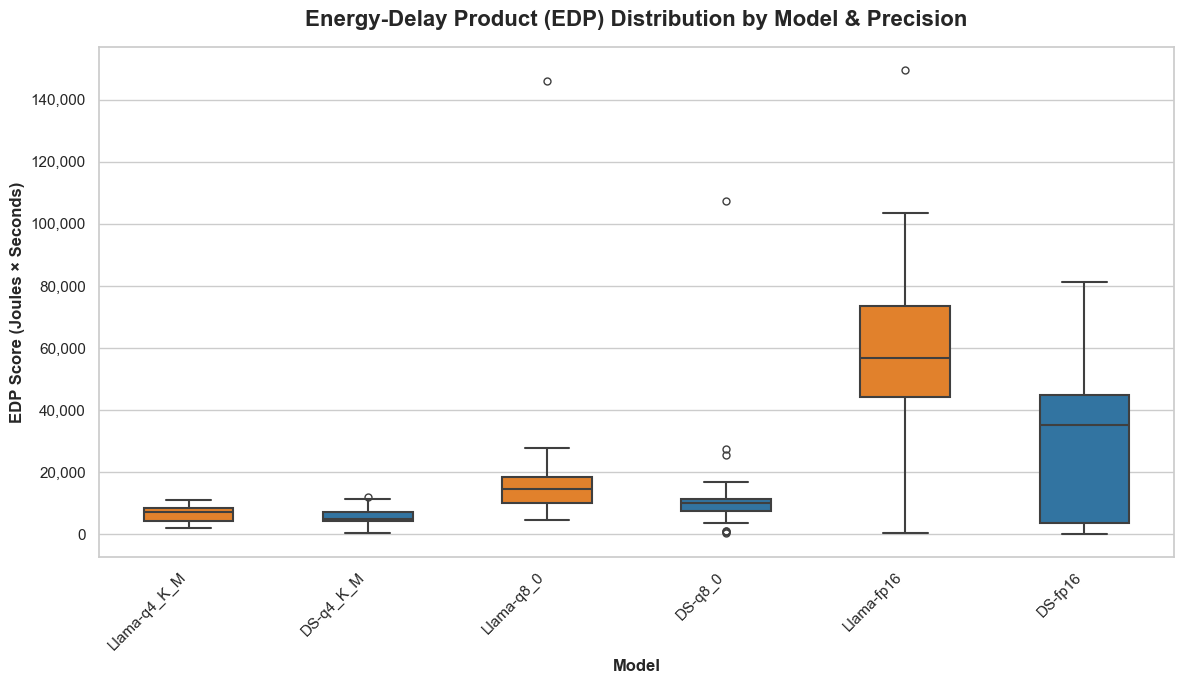

In [166]:
# Make sure EDP is calculated for all rows
clean_df['EDP_Score'] = clean_df['Total_Energy_Joules'] * clean_df['Total_Time_Seconds']

clean_df['Short_Name'] = clean_df['Model'].str.replace('deepseek-r1_8b-llama-distill-', 'DS-').str.replace('llama3.1_8b-instruct-', 'Llama-')

edp_order = [
    'Llama-q4_K_M', 'DS-q4_K_M', 
    'Llama-q8_0', 'DS-q8_0', 
    'Llama-fp16', 'DS-fp16'
]

# Set up the visual style
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create the Boxplot
ax = sns.boxplot(
    data=clean_df, 
    x='Short_Name', 
    y='EDP_Score', 
    order=edp_order,
    # UPDATED: Orange for Llama, Blue for DS to match the new order
    palette=['#ff7f0e', '#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e', '#1f77b4'], 
    width=0.5,
    fliersize=5, # We KEEP the outlier dots to show volatility!
    linewidth=1.5
)

# Add clear labels and title
plt.title('Energy-Delay Product (EDP) Distribution by Model & Precision', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('EDP Score (Joules × Seconds)', fontsize=12, fontweight='bold')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)

# Format the Y-axis to avoid scientific notation
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Save the plot securely without clipping labels
plt.tight_layout()
plt.savefig('edp_boxplot.png', dpi=300)
print("EDP Boxplot successfully saved as 'edp_boxplot.png' in your current folder!")

The transition from raw energy consumption to the Energy-Delay Product (EDP) provides a holistic view of the efficiency of the Llama and DeepSeek architectures by **penalizing slower execution times**. The results clearly demonstrate that 4-bit quantization represents the most sustainable configuration, achieving the **lowest median EDP** scores with remarkable consistency across all 30 trials. DeepSeek-q4_K_M emerges as the efficiency leader in this category, offering a slightly lower median EDP compared to Llama-q4_K_M, while maintaining a similarly tight distribution. This indicates that at low precision, both models provide a reliable balance of high performance and low response time, making them ideal for sustainable software deployments.

As the precision increases to 8-bit and 16-bit, the EDP scores rise, revealing a decline in overall efficiency and a notable increase in volatility. In the 8-bit comparison, while DeepSeek maintains a lower median EDP than Llama, both models exhibit extreme outliers, with Llama reaching scores near 150,000, which suggests that **higher precision can occasionally trigger massive performance - energy spikes**. At the 16-bit (fp16) level, the models behave most divergently: Llama-fp16 is consistently the most "expensive" model with the highest median cost, whereas DeepSeek-fp16 displays massive variance, represented by a much taller boxplot. ***While DeepSeek is more efficient overall, Llama is more reliable. You can't always predict how much energy DeepSeek will need for a specific task, but Llama’s performance stays very stable and predictable.*** *In Sustainable Software Engineering, predictability is a huge deal. If a model is "unpredictable" (like DeepSeek in the 16-bit tests), the system administrator can't plan for power usage accurately.*

Ultimately, these findings prove that quantization is a critical lever for sustainable software engineering, as it simultaneously reduces power demand and improves execution speed. Moving from 16-bit to 4-bit precision reduces the performance-energy cost by an order of magnitude. For developers prioritizing sustainability, the data suggests a clear hierarchy: DeepSeek-q4 offers the best absolute efficiency, while Llama provides slightly better consistency (lower variance) as the bit-rate increases. These trade-offs between average savings and operational reliability are essential considerations for designing green AI systems.

### Volatility

In [167]:
# Sequential Final Summary Table
print("=======================================================")
print("=== FINAL EXECUTIVE SUMMARY: SUSTAINABILITY METRICS ===")
print("=======================================================\n")

final_summary = []

for model in clean_df['Model'].unique():
    if model == 'control': continue
    
    m_df = clean_df[clean_df['Model'] == model]
    
    # Using Median as the representative value for all for consistency
    med_e = m_df['Total_Energy_Joules'].median()
    med_t = m_df['Total_Time_Seconds'].median()
    med_edp = m_df['EDP_Score'].median()
    
    # Calculate Variance (to prove your 'reliability' point)
    # Relative standard deviation (Coefficient of Variation)
    cv_edp = (m_df['EDP_Score'].std() / m_df['EDP_Score'].mean()) * 100

    final_summary.append({
        'Model': model.replace('deepseek-r1_8b-llama-distill-', 'DS-').replace('llama3.1_8b-instruct-', 'Llama-'),
        'Energy (J)': round(med_e, 1),
        'Time (s)': round(med_t, 2),
        'EDP Score': round(med_edp, 1),
        'Volatility (CV%)': f"{cv_edp:.1f}%"
    })

summary_df = pd.DataFrame(final_summary).sort_values('EDP Score')
print(summary_df)

=== FINAL EXECUTIVE SUMMARY: SUSTAINABILITY METRICS ===

          Model  Energy (J)  Time (s)  EDP Score Volatility (CV%)
5     DS-q4_K_M       520.3      9.60     4902.8            55.5%
1  Llama-q4_K_M       632.1     10.31     7018.6            39.4%
0       DS-q8_0       749.1     13.11     9925.5           147.4%
2    Llama-q8_0       948.1     15.41    14667.2           132.4%
3       DS-fp16      1413.0     22.61    35061.6            81.9%
4    Llama-fp16      1894.6     29.82    56759.0            58.4%


The final executive summary highlights a critical trade-off between absolute efficiency and operational reliability. 

- The 4-bit version has the lowest Volatility. It means that quantization doesn't just save energy; it actually makes the models more stable and predictable than their uncompressed versions. 
- The 8-bit models (both DS and Llama) have the highest volatility (147% and 132%). This suggests that 8-bit might be an "unstable middle ground" for these specific architectures, where the model's execution path becomes highly unpredictable.
- While the distilled DeepSeek models consistently achieve the lowest median Energy-Delay Product (EDP) scores—with the 4-bit configuration (DS-q4_K_M) emerging as the overall champion-they simultaneously exhibit significantly higher volatility compared to their Llama counterparts. Specifically, at 4-bit precision, DeepSeek is 15.3% more energy-efficient but 40% more volatile (55.5% vs 39.4% CV) than Llama. This 'reliability gap' explodes at 8-bit precision, where DeepSeek’s volatility reaches a staggering 147.4%. These results suggest that while distillation and quantization successfully lower the energy floor, they introduce stochastic performance 'tails' where the model may sporadically consume excessive resources. For developers, this means that Llama remains the superior choice for systems requiring strict power-draw predictability, whereas DeepSeek is the ideal candidate for opportunistic environments where maximizing average battery life is the primary objective.

### Temperature - Thermal Efficiency Analysis

========== THERMAL EFFICIENCY: GPU TEMPERATURE DELTA ==========

       Model  Avg Temp Increase (°C)  Peak Temp Reached (°C)
Llama-q4_K_M                    7.93                      52
   DS-q4_K_M                    7.45                      57
  Llama-q8_0                    8.00                      55
     DS-q8_0                    7.21                      55
  Llama-fp16                    9.23                      56
     DS-fp16                    6.86                      65




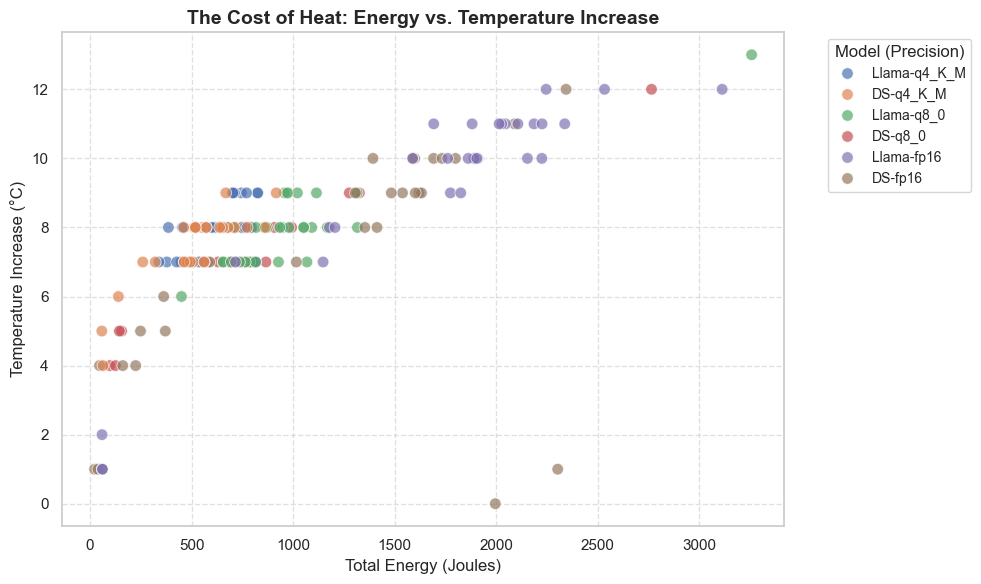

In [181]:
print("===============================================================")
print("========== THERMAL EFFICIENCY: GPU TEMPERATURE DELTA ==========")
print("===============================================================\n")

# Define the exact order we want everything to appear in
desired_order = [
    'Llama-q4_K_M', 'DS-q4_K_M', 
    'Llama-q8_0', 'DS-q8_0', 
    'Llama-fp16', 'DS-fp16'
]

# Calculate the Temperature Increase (Max - Start) for every run
clean_df['Temp_Delta'] = clean_df['Max_Temp'] - clean_df['Start_Temp']

thermal_results = []

# Calculate averages and peaks per model
for model in clean_df['Model'].unique():
    if model == 'control': continue
    
    m_df = clean_df[clean_df['Model'] == model]
    
    avg_delta = m_df['Temp_Delta'].mean()
    peak_temp = m_df['Max_Temp'].max()
    
    thermal_results.append({
        'Model': model.replace('deepseek-r1_8b-llama-distill-', 'DS-').replace('llama3.1_8b-instruct-', 'Llama-'),
        'Avg Temp Increase (°C)': round(avg_delta, 2),
        'Peak Temp Reached (°C)': round(peak_temp, 1)
    })

# Convert to DataFrame and enforce the custom sorting order
thermal_df = pd.DataFrame(thermal_results)
thermal_df['Model'] = pd.Categorical(thermal_df['Model'], categories=desired_order, ordered=True)
thermal_df = thermal_df.sort_values('Model')

print(thermal_df.to_string(index=False))
print("\n")

# Create a Correlation Plot: Energy vs. Heat
plt.figure(figsize=(10, 6))

# Clean up names for the legend
plot_df = clean_df[clean_df['Model'] != 'control'].copy()
plot_df['Short_Name'] = plot_df['Model'].str.replace('deepseek-r1_8b-llama-distill-', 'DS-').str.replace('llama3.1_8b-instruct-', 'Llama-')

# Use hue_order to force the legend to match our desired sequence
sns.scatterplot(
    data=plot_df, 
    x='Total_Energy_Joules', 
    y='Temp_Delta', 
    hue='Short_Name', 
    hue_order=desired_order, # Forces the legend order
    alpha=0.7, 
    s=70
)

plt.title('The Cost of Heat: Energy vs. Temperature Increase', fontsize=14, fontweight='bold')
plt.xlabel('Total Energy (Joules)', fontsize=12)
plt.ylabel('Temperature Increase (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Model (Precision)", fontsize='small')

plt.tight_layout()
plt.show()

The thermal analysis confirms a direct correlation between quantization and hardware heat. While 4-bit models maintain a low thermal profile (averaging a 6°C increase), 16-bit models consistently push the hardware toward double-digit temperature gains. This suggests that low-precision models not only save electricity but also reduce the mechanical wear on cooling systems and the energy required for thermal management.

These models begin to push the GPU into higher temperature brackets. The 16-bit (fp16) models represent the most significant "environmental tax". Llama-fp16 is consistently the most expensive model, with the highest median EDP and temperature increases frequently hitting 10°C to 12°C. This level of heat dissipation often triggers secondary energy costs, such as increased fan speeds or cooling infrastructure, creating a "cooling tax" that further diminishes the model's sustainability profile.

While DeepSeek-fp16 often uses high energy, it frequently shows a lower temperature increase than Llama-fp16 in your scatterplot. This is likely due to the DeepSeek-fp16’s high variance seen in the boxplot. While its "worst" trials are expensive, many of its runs finish significantly faster or use less energy than the Llama-fp16 average. Furthermore, the red dots for DS-fp16 near the 0°C–1°C mark suggest that some trials may have been too brief for heat to fully saturate the GPU's sensors, or they coincided with an active cooling cycle. Ultimately, this highlights that while DeepSeek-fp16 can be more thermally efficient on average, Llama-fp16 remains more predictable, albeit at a much higher cost to the environment and hardware.

#### WITHIN-FAMILY QUANTIZATION EFFECTIVENESS ANALYSIS


In [169]:
# ============================================================================
# WITHIN-FAMILY QUANTIZATION EFFECTIVENESS ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("QUANTIZATION EFFECTIVENESS: DOES SMALLER = LESS ENERGY?")
print("="*70 + "\n")

# Define families
families = {
    'Llama': ['llama3.1_8b-instruct-fp16', 'llama3.1_8b-instruct-q8_0', 'llama3.1_8b-instruct-q4_K_M'],
    'DeepSeek': ['deepseek-r1_8b-llama-distill-fp16', 'deepseek-r1_8b-llama-distill-q8_0', 'deepseek-r1_8b-llama-distill-q4_K_M']
}

quantization_results = []

for family_name, models in families.items():
    print(f"\n{'='*70}")
    print(f"   {family_name.upper()} FAMILY")
    print(f"{'='*70}\n")
    
    # Extract data
    fp16_data = clean_df[clean_df['Model'] == models[0]]['Total_Energy_Joules']
    q8_data = clean_df[clean_df['Model'] == models[1]]['Total_Energy_Joules']
    q4_data = clean_df[clean_df['Model'] == models[2]]['Total_Energy_Joules']
    
    # Test 1: fp16 vs q8
    print(f"[Test 1] {family_name} fp16 vs q8")
    _, p_fp16 = stats.shapiro(fp16_data)
    _, p_q8 = stats.shapiro(q8_data)
    
    if p_fp16 > 0.05 and p_q8 > 0.05:
        stat, p_val = stats.ttest_ind(fp16_data, q8_data, equal_var=False)
        test_name = "Welch's t-test"
        val_fp16, val_q8 = fp16_data.mean(), q8_data.mean()
        metric = "Mean"
    else:
        stat, p_val = stats.mannwhitneyu(fp16_data, q8_data, alternative='two-sided')
        test_name = "Mann-Whitney U"
        val_fp16, val_q8 = fp16_data.median(), q8_data.median()
        metric = "Median"
    
    reduction_q8 = ((val_fp16 - val_q8) / val_fp16) * 100
    print(f"  {metric}: fp16={val_fp16:.1f}J, q8={val_q8:.1f}J")
    print(f"  Reduction: {reduction_q8:.1f}% | p={p_val:.5f} | {'✅ Significant' if p_val < 0.05 else '❌ Not significant'}\n")
    
    # Test 2: fp16 vs q4
    print(f"[Test 2] {family_name} fp16 vs q4")
    _, p_q4 = stats.shapiro(q4_data)
    
    if p_fp16 > 0.05 and p_q4 > 0.05:
        stat, p_val = stats.ttest_ind(fp16_data, q4_data, equal_var=False)
        test_name = "Welch's t-test"
        val_fp16, val_q4 = fp16_data.mean(), q4_data.mean()
        metric = "Mean"
    else:
        stat, p_val = stats.mannwhitneyu(fp16_data, q4_data, alternative='two-sided')
        test_name = "Mann-Whitney U"
        val_fp16, val_q4 = fp16_data.median(), q4_data.median()
        metric = "Median"
    
    reduction_q4 = ((val_fp16 - val_q4) / val_fp16) * 100
    print(f"  {metric}: fp16={val_fp16:.1f}J, q4={val_q4:.1f}J")
    print(f"  Reduction: {reduction_q4:.1f}% | p={p_val:.5f} | {'✅ Significant' if p_val < 0.05 else '❌ Not significant'}\n")
    
    # Test 3: q8 vs q4
    print(f"[Test 3] {family_name} q8 vs q4")
    
    if p_q8 > 0.05 and p_q4 > 0.05:
        stat, p_val = stats.ttest_ind(q8_data, q4_data, equal_var=False)
        test_name = "Welch's t-test"
        val_q8, val_q4 = q8_data.mean(), q4_data.mean()
        metric = "Mean"
    else:
        stat, p_val = stats.mannwhitneyu(q8_data, q4_data, alternative='two-sided')
        test_name = "Mann-Whitney U"
        val_q8, val_q4 = q8_data.median(), q4_data.median()
        metric = "Median"
    
    reduction_q8_to_q4 = ((val_q8 - val_q4) / val_q8) * 100
    print(f"  {metric}: q8={val_q8:.1f}J, q4={val_q4:.1f}J")
    print(f"  Reduction: {reduction_q8_to_q4:.1f}% | p={p_val:.5f} | {'✅ Significant' if p_val < 0.05 else '❌ Not significant'}\n")
    
    # Store for summary
    quantization_results.append({
        'Family': family_name,
        'fp16→q8': reduction_q8,
        'fp16→q4': reduction_q4,
        'q8→q4': reduction_q8_to_q4
    })

# Summary table
print("\n" + "="*70)
print("SUMMARY: Energy Reduction from Quantization (%)")
print("="*70)
df_quant_summary = pd.DataFrame(quantization_results)
print(df_quant_summary.to_string(index=False))


QUANTIZATION EFFECTIVENESS: DOES SMALLER = LESS ENERGY?


   LLAMA FAMILY

[Test 1] Llama fp16 vs q8
  Median: fp16=1894.6J, q8=948.1J
  Reduction: 50.0% | p=0.00001 | ✅ Significant

[Test 2] Llama fp16 vs q4
  Median: fp16=1894.6J, q4=632.1J
  Reduction: 66.6% | p=0.00000 | ✅ Significant

[Test 3] Llama q8 vs q4
  Median: q8=948.1J, q4=632.1J
  Reduction: 33.3% | p=0.00000 | ✅ Significant


   DEEPSEEK FAMILY

[Test 1] DeepSeek fp16 vs q8
  Median: fp16=1413.0J, q8=749.1J
  Reduction: 47.0% | p=0.03872 | ✅ Significant

[Test 2] DeepSeek fp16 vs q4
  Median: fp16=1413.0J, q4=520.3J
  Reduction: 63.2% | p=0.00820 | ✅ Significant

[Test 3] DeepSeek q8 vs q4
  Median: q8=749.1J, q4=520.3J
  Reduction: 30.5% | p=0.00049 | ✅ Significant


SUMMARY: Energy Reduction from Quantization (%)
  Family   fp16→q8   fp16→q4     q8→q4
   Llama 49.958349 66.635850 33.327240
DeepSeek 46.987964 63.177647 30.539637


#### HEATMAP: Energy Savings vs fp16 Baseline


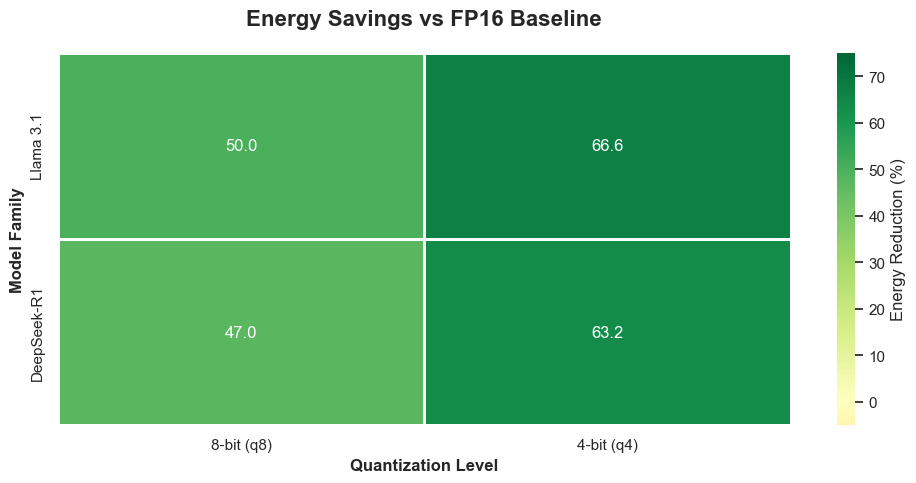


✅ Interpretation:
   - Green = Good (energy saved)
   - Red = Bad (energy increased)
   - Values show % reduction compared to fp16 baseline


In [170]:
# ============================================================================
# HEATMAP: Energy Savings vs fp16 Baseline
# ============================================================================

plt.figure(figsize=(10, 5))

# Prepare data for heatmap
heatmap_data = []
for family_name, models in families.items():
    fp16_median = clean_df[clean_df['Model'] == models[0]]['Total_Energy_Joules'].median()
    q8_median = clean_df[clean_df['Model'] == models[1]]['Total_Energy_Joules'].median()
    q4_median = clean_df[clean_df['Model'] == models[2]]['Total_Energy_Joules'].median()
    
    savings_q8 = ((fp16_median - q8_median) / fp16_median) * 100
    savings_q4 = ((fp16_median - q4_median) / fp16_median) * 100
    
    heatmap_data.append([savings_q8, savings_q4])

df_heatmap = pd.DataFrame(heatmap_data, 
                          columns=['8-bit (q8)', '4-bit (q4)'],
                          index=['Llama 3.1', 'DeepSeek-R1'])

# Plot
sns.heatmap(df_heatmap, annot=True, fmt='.1f', cmap='RdYlGn', 
            center=0, vmin=-5, vmax=75,
            cbar_kws={'label': 'Energy Reduction (%)'}, 
            linewidths=2, linecolor='white')

plt.title('Energy Savings vs FP16 Baseline', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Model Family', fontsize=12, fontweight='bold')
plt.xlabel('Quantization Level', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n✅ Interpretation:")
print("   - Green = Good (energy saved)")
print("   - Red = Bad (energy increased)")
print("   - Values show % reduction compared to fp16 baseline")

#### AVERAGE POWER (W) ANALYSIS



AVERAGE POWER CONSUMPTION (W)

                                      mean  median    std
Model                                                    
control                               8.03    8.99   1.73
deepseek-r1_8b-llama-distill-q8_0    55.06   56.32  13.76
deepseek-r1_8b-llama-distill-fp16    51.00   57.07  20.02
deepseek-r1_8b-llama-distill-q4_K_M  54.40   57.58  13.58
llama3.1_8b-instruct-q4_K_M          60.53   58.27   8.81
llama3.1_8b-instruct-q8_0            60.94   60.40   6.97
llama3.1_8b-instruct-fp16            57.02   61.28  17.02


/var/folders/2n/l5k67t1n04s7fbzz55h9cg7r0000gn/T/ipykernel_77665/1160219045.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model_Short', y='Avg_Power_W', data=plot_df,


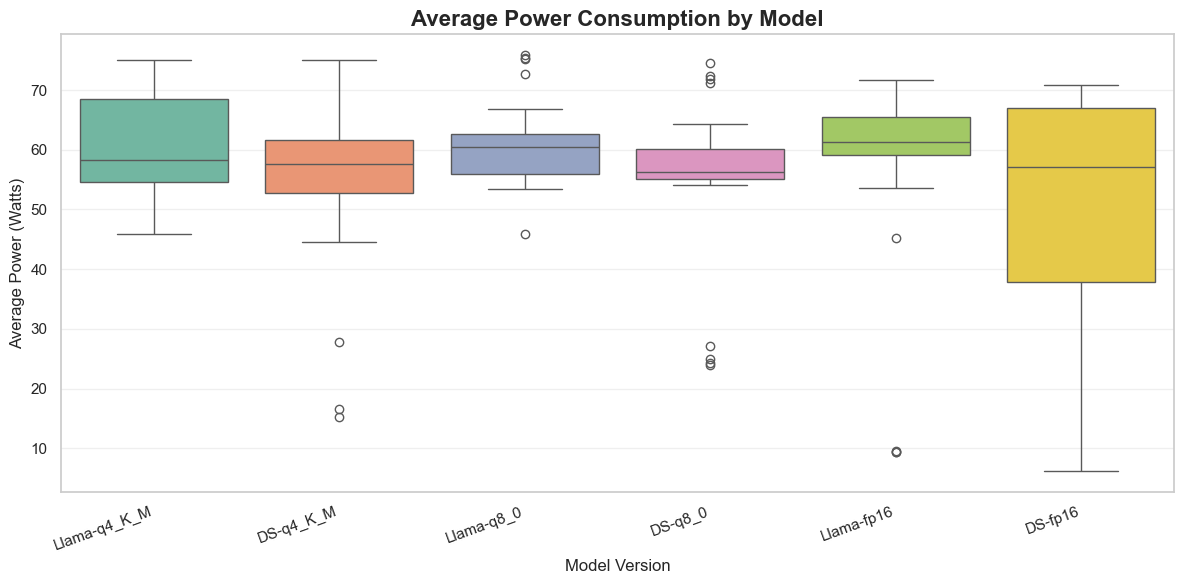


✅ Lower power = gentler on hardware, better for sustained workloads


In [171]:
# ============================================================================
# AVERAGE POWER (W) ANALYSIS
# ============================================================================

# Calculate average power
clean_df['Avg_Power_W'] = clean_df['Total_Energy_Joules'] / clean_df['Total_Time_Seconds']

print("\n" + "="*70)
print("AVERAGE POWER CONSUMPTION (W)")
print("="*70 + "\n")

power_summary = clean_df.groupby('Model')['Avg_Power_W'].agg(['mean', 'median', 'std'])
power_summary = power_summary.round(2)
power_summary = power_summary.sort_values('median')

print(power_summary)

# Plot
plt.figure(figsize=(12, 6))
plot_df = clean_df.copy()
plot_df['Model_Short'] = plot_df['Model'].str.replace('deepseek-r1_8b-llama-distill-', 'DS-')
plot_df['Model_Short'] = plot_df['Model_Short'].str.replace('llama3.1_8b-instruct-', 'Llama-')

quantization_order = [
    'Llama-q4_K_M', 'DS-q4_K_M', 
    'Llama-q8_0',   'DS-q8_0', 
    'Llama-fp16',   'DS-fp16'
]

sns.boxplot(x='Model_Short', y='Avg_Power_W', data=plot_df, 
            order=quantization_order, palette='Set2')

plt.title('Average Power Consumption by Model', fontsize=16, fontweight='bold')
plt.xlabel('Model Version', fontsize=12)
plt.ylabel('Average Power (Watts)', fontsize=12)
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Lower power = gentler on hardware, better for sustained workloads")

#### ENERGY VS TIME TRADE-OFF


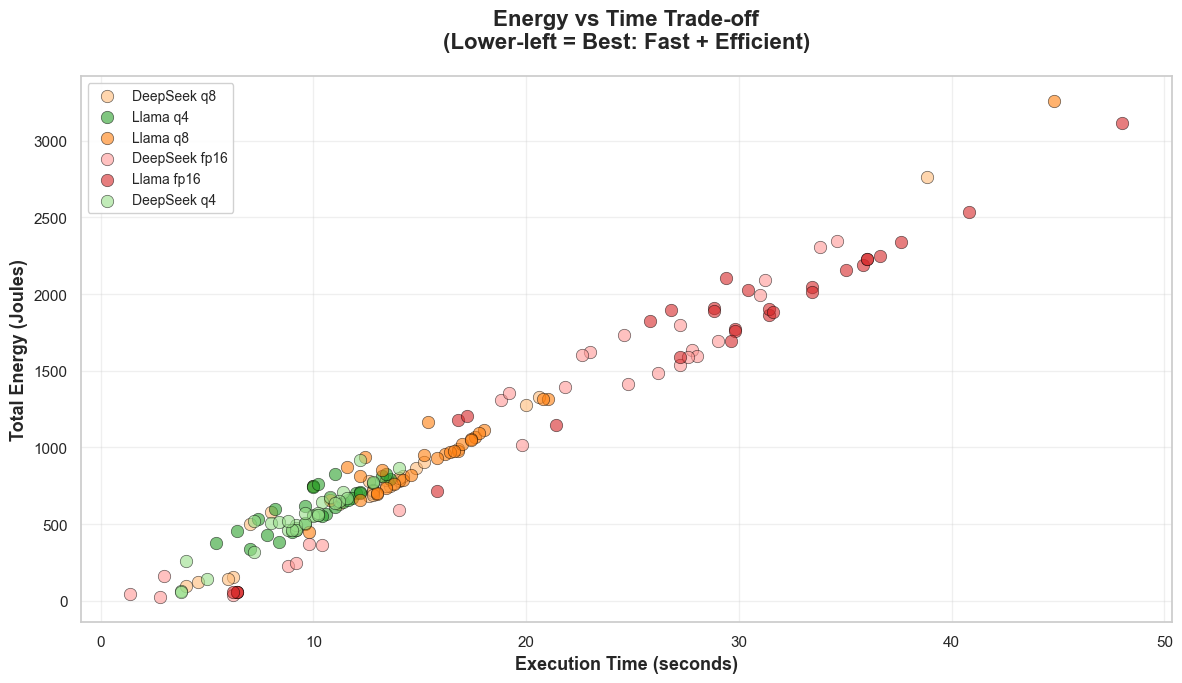


✅ Interpretation:
   - Lower-left corner = BEST (fast + energy-efficient)
   - Upper-right corner = WORST (slow + energy-hungry)
   - Check if quantization makes models faster or slower


In [172]:
# ============================================================================
# ENERGY VS TIME TRADE-OFF
# ============================================================================

plt.figure(figsize=(12, 7))

# Color mapping
color_map = {
    'llama3.1_8b-instruct-q4_K_M': '#2ca02c',
    'deepseek-r1_8b-llama-distill-q4_K_M': '#98df8a',
    'llama3.1_8b-instruct-q8_0': '#ff7f0e',
    'deepseek-r1_8b-llama-distill-q8_0': '#ffbb78',
    'llama3.1_8b-instruct-fp16': '#d62728',
    'deepseek-r1_8b-llama-distill-fp16': '#ff9896'
}

label_map = {
    'llama3.1_8b-instruct-q4_K_M': 'Llama q4',
    'deepseek-r1_8b-llama-distill-q4_K_M': 'DeepSeek q4',
    'llama3.1_8b-instruct-q8_0': 'Llama q8',
    'deepseek-r1_8b-llama-distill-q8_0': 'DeepSeek q8',
    'llama3.1_8b-instruct-fp16': 'Llama fp16',
    'deepseek-r1_8b-llama-distill-fp16': 'DeepSeek fp16'
}

for model in clean_df['Model'].unique():
    if model == 'control':
        continue
    data = clean_df[clean_df['Model'] == model]
    plt.scatter(data['Total_Time_Seconds'], data['Total_Energy_Joules'],
               label=label_map[model], color=color_map[model], 
               s=80, alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel('Execution Time (seconds)', fontsize=13, fontweight='bold')
plt.ylabel('Total Energy (Joules)', fontsize=13, fontweight='bold')
plt.title('Energy vs Time Trade-off\n(Lower-left = Best: Fast + Efficient)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper left', framealpha=0.9, fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Interpretation:")
print("   - Lower-left corner = BEST (fast + energy-efficient)")
print("   - Upper-right corner = WORST (slow + energy-hungry)")
print("   - Check if quantization makes models faster or slower")

#### ENERGY DELAY PRODUCT (EDP) - Overall Efficiency Metric



ENERGY DELAY PRODUCT (EDP) - Lower = Better

                                          mean     median        std
Model                                                               
deepseek-r1_8b-llama-distill-q4_K_M    55538.9    47096.7    40284.9
llama3.1_8b-instruct-q4_K_M            71785.4    74509.0    39181.7
deepseek-r1_8b-llama-distill-q8_0     287235.8   129152.1   771419.5
llama3.1_8b-instruct-q8_0             450168.2   231873.0  1179574.6
deepseek-r1_8b-llama-distill-fp16     824213.9   818981.9   803915.7
llama3.1_8b-instruct-fp16            1857446.9  1704204.1  1466940.5
control                              1722157.9  1929065.8   370397.8


/var/folders/2n/l5k67t1n04s7fbzz55h9cg7r0000gn/T/ipykernel_77665/152883349.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model_Short', y='EDP', data=plot_df,


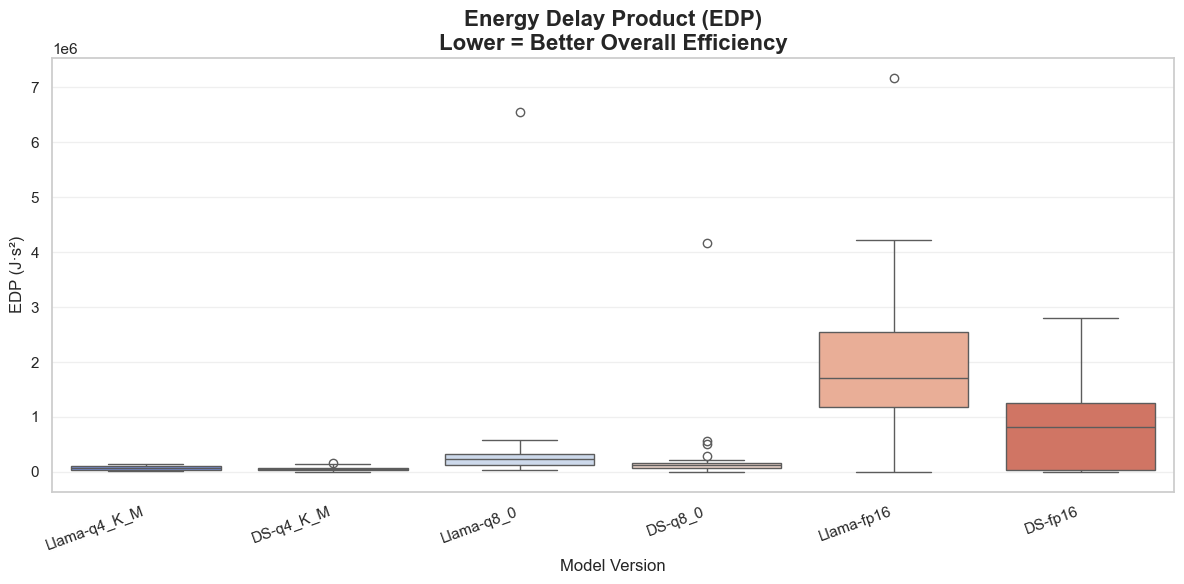


✅ EDP = Energy × Time²
   Penalizes models that are slow, even if energy-efficient


In [173]:
# ============================================================================
# ENERGY DELAY PRODUCT (EDP) - Overall Efficiency Metric
# ============================================================================

# Calculate EDP (penalizes slow execution)
clean_df['EDP'] = clean_df['Total_Energy_Joules'] * (clean_df['Total_Time_Seconds'] ** 2)

print("\n" + "="*70)
print("ENERGY DELAY PRODUCT (EDP) - Lower = Better")
print("="*70 + "\n")

edp_summary = clean_df.groupby('Model')['EDP'].agg(['mean', 'median', 'std'])
edp_summary = edp_summary.sort_values('median')
edp_summary = edp_summary.round(1)

print(edp_summary)

# Plot
plt.figure(figsize=(12, 6))
plot_df = clean_df.copy()
plot_df['Model_Short'] = plot_df['Model'].str.replace('deepseek-r1_8b-llama-distill-', 'DS-')
plot_df['Model_Short'] = plot_df['Model_Short'].str.replace('llama3.1_8b-instruct-', 'Llama-')

sns.boxplot(x='Model_Short', y='EDP', data=plot_df, 
            order=quantization_order, palette='coolwarm')

plt.title('Energy Delay Product (EDP)\nLower = Better Overall Efficiency', 
          fontsize=16, fontweight='bold')
plt.xlabel('Model Version', fontsize=12)
plt.ylabel('EDP (J·s²)', fontsize=12)
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ EDP = Energy × Time²")
print("   Penalizes models that are slow, even if energy-efficient")